In [1]:
import pvdeg
import os

import matplotlib.pyplot as plt
from copy import deepcopy

import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import numpy as np

from sklearn.neighbors import KDTree
import joblib

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, LineString, MultiLineString

In [2]:
# if we get the nsrdb file names then using weather.get_NSRDB_fnames we can read and save as a KDTree?
path = '/datasets/NSRDB/current/nsrdb_2022.h5'

print(os.path.getsize(path)) # in bytes

1599024660702


In [3]:
weather_db = 'NSRDB'

weather_arg = {'satellite': 'Americas',
               'names': 2022,
               'NREL_HPC': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_ds, meta_df = pvdeg.weather.get(weather_db, geospatial=True, **weather_arg)

meta_df['gid'] = meta_df.index
meta_dupe = deepcopy(meta_df)

meta_sub = meta_dupe.iloc[::100]
meta_sub.drop(['tz','country','state','county','wind_height'], axis=1)

/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


,latitude,longitude,altitude,gid
0,-15.950000,-179.979996,0,0
100,-16.510000,-179.899994,0,100
200,-17.070000,-179.820007,0,200
300,-16.629999,-179.699997,0,300
400,-17.590000,-179.380005,0,400
...,...,...,...,...
2017800,15.410000,-23.100000,0,2017800
2017900,15.170000,-23.020000,0,2017900
2018000,17.049999,-22.900000,0,2018000
2018100,16.889999,-22.780001,0,2018100


Text(0.5, 1.0, 'Downsampled Points')

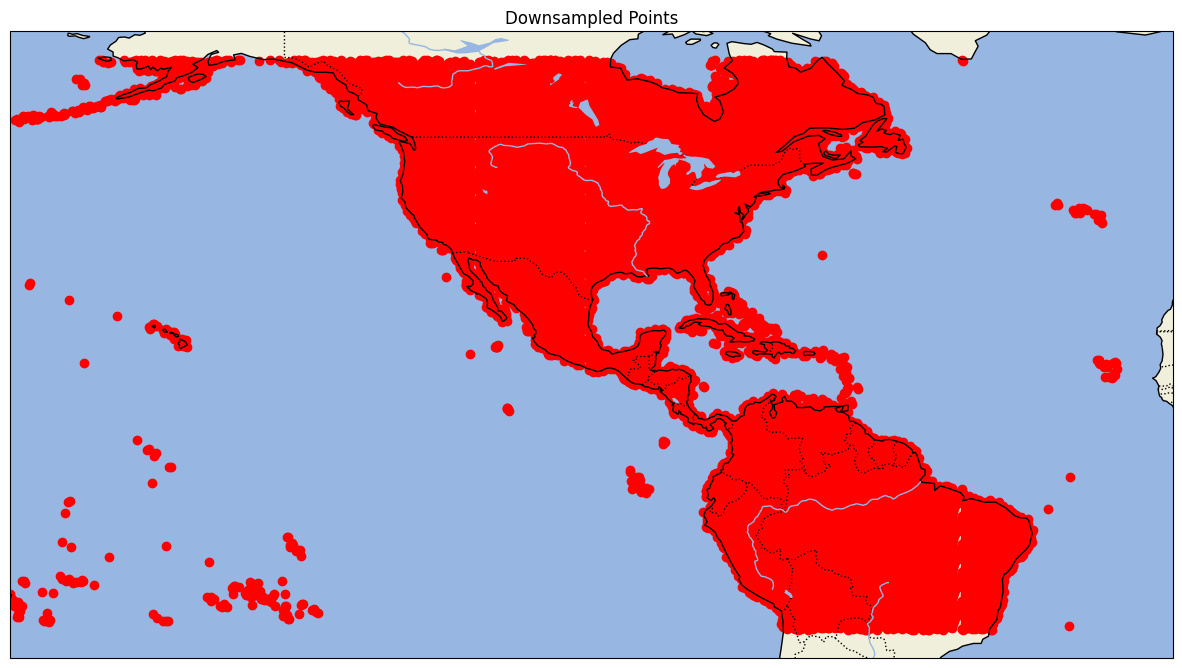

In [4]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

ax.scatter(meta_sub['longitude'], meta_sub['latitude'], color='red',transform=ccrs.PlateCarree())

plt.title('Downsampled Points')

In [5]:
coordinates = meta_sub[['latitude', 'longitude']].values
elevations = meta_sub['altitude'].values

tree = KDTree(coordinates, leaf_size=40) # what is the optimal leaf size

joblib.dump(tree, 'kdtree.pkl')

['kdtree.pkl']

In [6]:
# Extract coordinates and elevation
coordinates = meta_sub[['latitude', 'longitude']].values
elevations = meta_sub['altitude'].values

# Build the KDTree
tree = KDTree(coordinates, leaf_size=40)

# Function to identify mountains based on relative elevations
def tobin_mountains(index, rad_1=12, rad_2=1, threshold_factor=1.25):
    # Reshape the coordinate array to 2D
    query_point = coordinates[index].reshape(1, -1)
    
    # Query the KDTree for neighbors within the specified radii
    area_points = tree.query_radius(query_point, r=rad_1)[0]
    local_points = tree.query_radius(query_point, r=rad_2)[0]

    # If no area points are found, return False
    if len(area_points) == 0:
        return False

    # Calculate mean elevations for the area and local points
    area_elevations = elevations[area_points]
    local_elevations = elevations[local_points]
    area_mean = np.mean(area_elevations)
    local_mean = np.mean(local_elevations)

    # Determine if the point is a mountain based on the threshold factor
    if local_mean > area_mean * threshold_factor:
        return True
    
    return False

# Apply the function to all points
meta_sub.loc[:,'is_mountain'] = [tobin_mountains(i) for i in range(len(meta_sub))]

/tmp/ipykernel_3039581/1928540973.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_sub.loc[:,'is_mountain'] = [tobin_mountains(i) for i in range(len(meta_sub))]


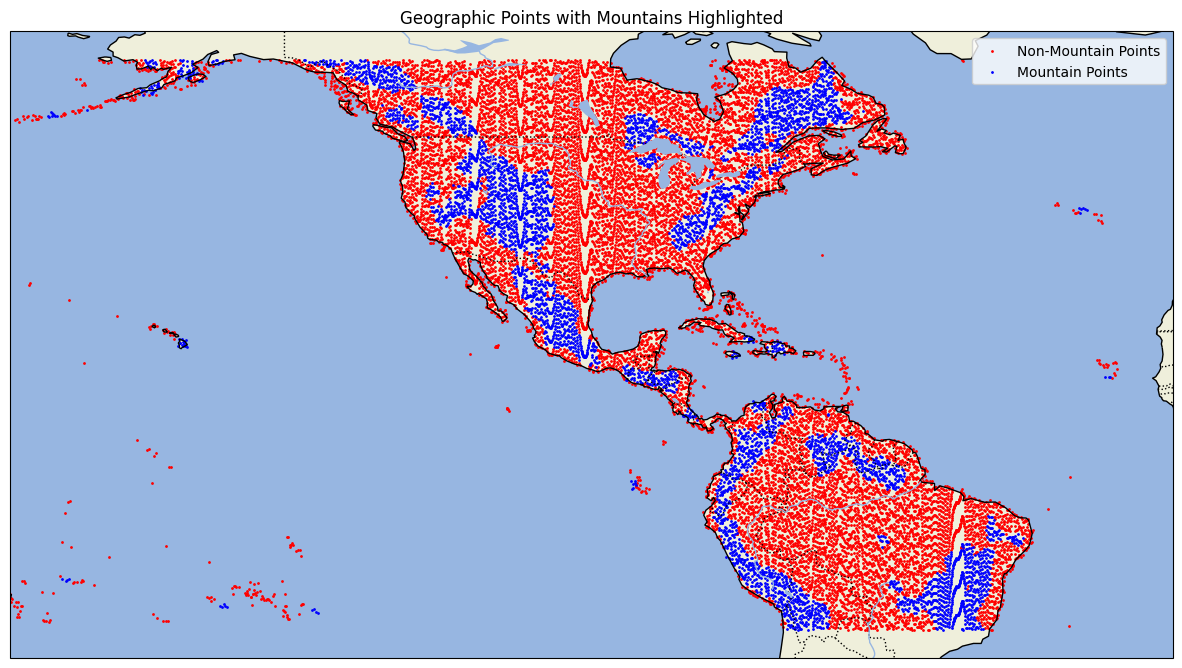

In [7]:
# Separate the meta_sub into mountains and non-mountains
mountains = meta_sub[meta_sub['is_mountain'] == True]
non_mountains = meta_sub[meta_sub['is_mountain'] == False]

# Plotting with Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot non-mountain points in red with smaller size
ax.scatter(non_mountains['longitude'], non_mountains['latitude'], color='red', s=1, transform=ccrs.PlateCarree(), label='Non-Mountain Points')

# Plot mountain points in blue with smaller size
ax.scatter(mountains['longitude'], mountains['latitude'], color='blue', s=1, transform=ccrs.PlateCarree(), label='Mountain Points')

# Set title and legend
plt.title('Geographic Points with Mountains Highlighted')
plt.legend()

# Show the plot
plt.show()

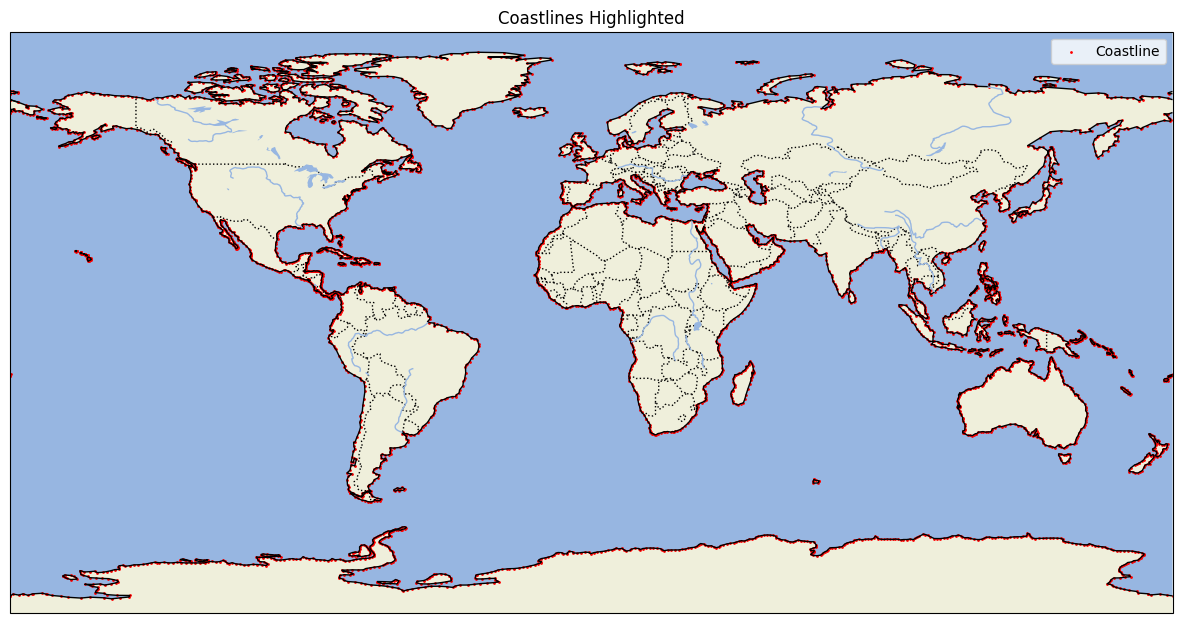

In [8]:
coastline_feature = cfeature.COASTLINE
coastline_geometries = []

for geom in coastline_feature.geometries():
    if isinstance(geom, LineString):
        coastline_geometries.append(geom)
    elif isinstance(geom, MultiLineString):
        for line in geom:
            coastline_geometries.append(line)

coastline_points = []
for geom in coastline_geometries:
    coords = list(geom.coords)
    for coord in coords:
        coastline_points.append(coord)

coastline_coords = np.array(coastline_points)

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot points not near the coastline in red with smaller size
ax.scatter(coastline_coords[:,0], coastline_coords[:,1], color='red', s=1, transform=ccrs.PlateCarree(), label='Coastline')

# Set title and legend
plt.title('Coastlines Highlighted')
plt.legend()

# Show the plot
plt.show()

In [11]:
def coastline_points(meta_df, kdtree, radius=1):
    coastline_feature = cfeature.COASTLINE
    coastline_geometries = []

    # Collect coastline geometries
    for geom in coastline_feature.geometries():
        if isinstance(geom, LineString):
            coastline_geometries.append(geom)
        elif isinstance(geom, MultiLineString):
            for line in geom.geoms:  # Correctly access the LineString objects
                coastline_geometries.append(line)

    # Extract points from geometries
    coastline_points = []
    for geom in coastline_geometries:
        coords = list(geom.coords)
        for coord in coords:
            coastline_points.append(coord)

    coastline_coords = np.array(coastline_points, dtype=np.float32)
    print(f"Number of coastline points: {len(coastline_coords)}")


    meta_df.loc[:,'coastline'] = False # this raises an error but works as expected

    include_set = set()
    for coord in coastline_coords:
        coord = np.array(coord).reshape(1, -1)  
        flipped_coord = coord[:, [1,0]] # biggest headache of my life to figure out that these were flipped
        indices = kdtree.query_radius(flipped_coord, radius)[0]  # Finds coastline indexes in the original data
        include_set.update(indices.tolist())

    include_arr = np.fromiter(include_set, dtype=int, count=len(include_set))
    meta_df.iloc[include_arr, meta_sub.columns.get_loc('coastline')] = True

In [12]:
coastline_points(meta_sub, tree)

Number of coastline points: 60416


/tmp/ipykernel_3039581/352980335.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df.loc[:,'coastline'] = False


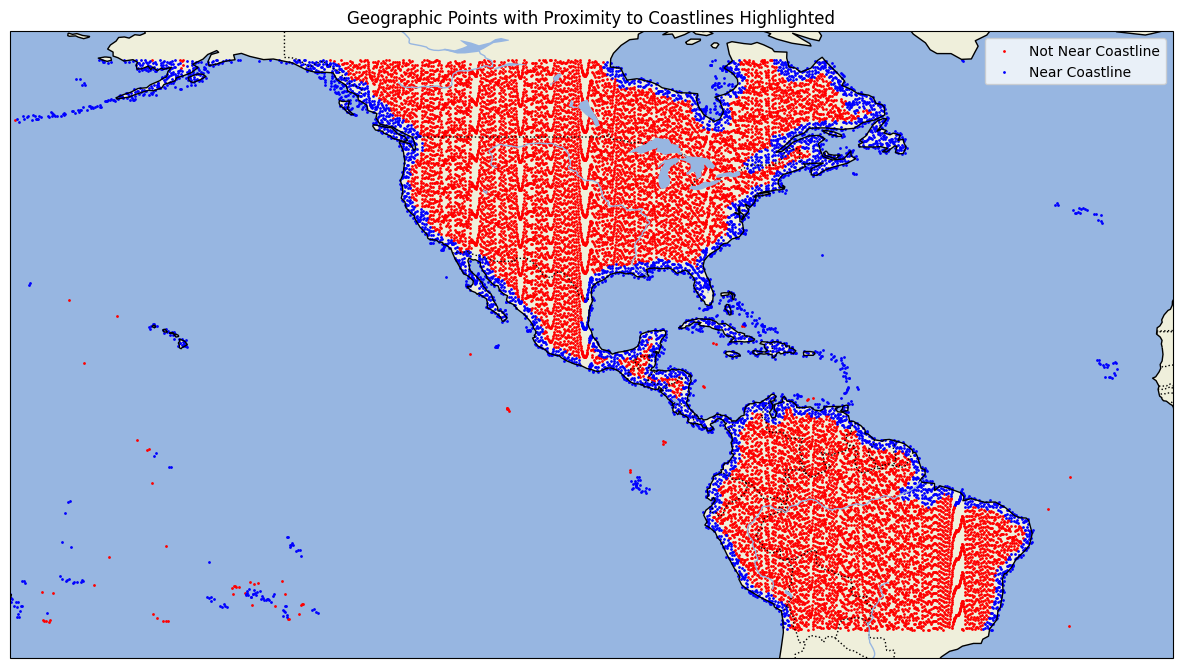

In [13]:
# Separate the data into points near and not near coastlines
near_coastline = meta_sub[meta_sub['coastline'] == True]
not_near_coastline = meta_sub[meta_sub['coastline'] == False]

# Plotting with Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot points not near the coastline in red with smaller size
ax.scatter(not_near_coastline['longitude'], not_near_coastline['latitude'], color='red', s=1, transform=ccrs.PlateCarree(), label='Not Near Coastline')

# Plot points near the coastline in blue with smaller size
ax.scatter(near_coastline['longitude'], near_coastline['latitude'], color='blue', s=1, transform=ccrs.PlateCarree(), label='Near Coastline')

# Set title and legend
plt.title('Geographic Points with Proximity to Coastlines Highlighted')
plt.legend()

# Show the plot
plt.show()